In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
from flask import Flask, jsonify

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# measurement_table = Table('measurement', axis, autoload=True, autoload_with=engine)


In [8]:
for class_ in Base.classes:
    print(class_)


<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [9]:
# Create our session (link) from Python to the DB

conn = engine.connect()
station_data = pd.read_sql ("SELECT * FROM station", conn)

print(station_data)

   id      station                                    name  latitude  \
0   1  USC00519397                    WAIKIKI 717.2, HI US  21.27160   
1   2  USC00513117                    KANEOHE 838.1, HI US  21.42340   
2   3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
3   4  USC00517948                       PEARL CITY, HI US  21.39340   
4   5  USC00518838              UPPER WAHIAWA 874.3, HI US  21.49920   
5   6  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
6   7  USC00519281                     WAIHEE 837.5, HI US  21.45167   
7   8  USC00511918       HONOLULU OBSERVATORY 702.2, HI US  21.31520   
8   9  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310   

   longitude  elevation  
0 -157.81680        3.0  
1 -157.80150       14.6  
2 -157.83740        7.0  
3 -157.97510       11.9  
4 -158.01110      306.6  
5 -157.71139       19.5  
6 -157.84889       32.9  
7 -157.99920        0.9  
8 -157.80250      152.4  


In [10]:
measurement_data = pd.read_sql ("SELECT * FROM measurement", conn)
print(measurement_data)

          id      station        date  prcp  tobs
0          1  USC00519397  2010-01-01  0.08  65.0
1          2  USC00519397  2010-01-02  0.00  63.0
2          3  USC00519397  2010-01-03  0.00  74.0
3          4  USC00519397  2010-01-04  0.00  76.0
4          5  USC00519397  2010-01-06   NaN  73.0
...      ...          ...         ...   ...   ...
19545  19546  USC00516128  2017-08-19  0.09  71.0
19546  19547  USC00516128  2017-08-20   NaN  78.0
19547  19548  USC00516128  2017-08-21  0.56  76.0
19548  19549  USC00516128  2017-08-22  0.50  76.0
19549  19550  USC00516128  2017-08-23  0.45  76.0

[19550 rows x 5 columns]


In [11]:
session = Session(engine)

In [13]:
start_date = dt.date(2018, 5, 22)
end_date = dt.date(2018, 6, 5)

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])
precip_df.set_index('date', inplace = True)
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


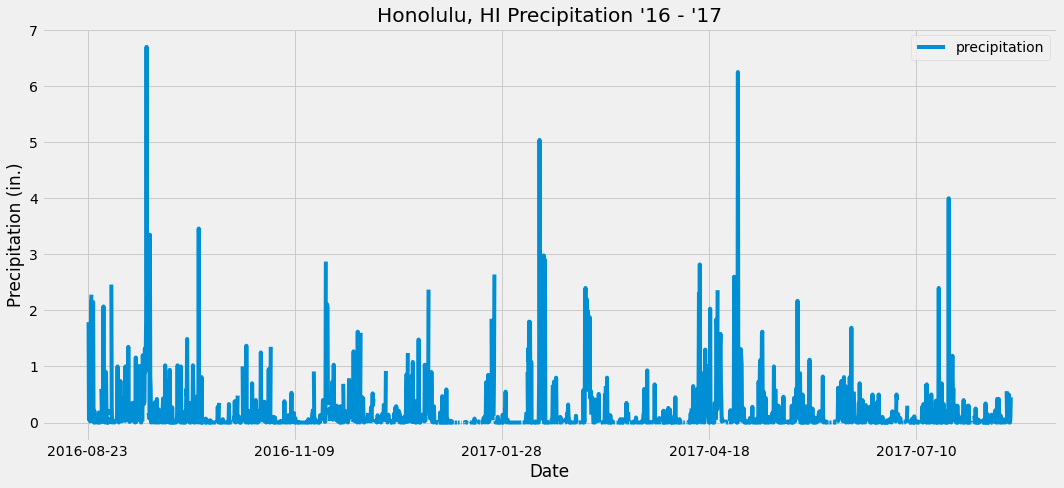

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

#save figure
plt.savefig("precip.png")

#plot figure
plt.tight_layout()
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data 
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [39]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Measurement.station).distinct().count()
number_stations

9

ArgumentError: argument is not a mapped class, mapper, aliased(), or FromClause instance.

In [54]:
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

# station_df = pd.DataFrame(active_stations)

# station_df.head()

for row in active_stations:
    print(row[0], row[1])


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?

max_station = session.query(Measurement.station, func.max(Measurement.station)).select_from(Station.station).\
max_station

In [67]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == max_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

OperationalError: (sqlite3.OperationalError) row value misused
[SQL: SELECT min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 
FROM measurement 
WHERE measurement.station = (SELECT measurement.station AS measurement_station, max() AS max_2 
FROM measurement)]
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [ ]:
# Choose the station with the highest number of temperature observations.



# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# BONUS

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))